<a href="https://colab.research.google.com/github/mxpoch/PCF/blob/main/PCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# key words:
# savings = constant
# none = reserved for root parent

In [65]:
# authentication
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [251]:
# importing
import pandas as pd
import matplotlib.pyplot as plt
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1X4ahQA0pLWN3dd4X64pKShYLzDhvdM3frwBqAY7FfXY/edit?usp=sharing')

read_inputnodes = wb.worksheet('InputNodes').get_all_values()
read_indextree = wb.worksheet('IndexTree').get_all_values()

raw_inputnodes = pd.DataFrame(read_inputnodes[1:], columns=read_inputnodes[0])
# gspread imports everything as string, converting value and timeframe columns to numeric
raw_inputnodes = raw_inputnodes.drop(columns=['value', 'period', 'percent']).join(raw_inputnodes[['value', 'period', 'percent']].apply(pd.to_numeric))

raw_indextree = pd.DataFrame(read_indextree[1:], columns=read_indextree[0])

In [252]:
raw_inputnodes

,name,startdate,enddate,parent,ratetype,value,period,percent
0,rent,09012021,01012021,tuition&fees,linear,-6392,120,0.0
1,sci_fees,09012021,01012021,tuition&fees,linear,-8,30,0.0
2,food,09012021,01012021,root,linear,-40,1,0.0
3,shoes,09012021,01012021,money,constant,-900,1,0.0
4,debt,09012021,1012021,money,compound,400,5,1.7


In [253]:
import datetime
class IndexTree:
    def __init__(self, raw_indextree:pd.DataFrame(), raw_inputnodes:pd.DataFrame()): 
        # print(raw_indextree)
        self.indexdict = self.build_index_tree(raw_indextree, raw_inputnodes)
        self.valuedict = self.build_input_nodes(raw_inputnodes)
        self.daymonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    def build_input_nodes(self, raw_inputnodes:pd.DataFrame()) -> dict:
        retdict = {}
        for i in range(raw_inputnodes.shape[0]):
            current = raw_inputnodes.iloc[i]
            retdict[current['name'].replace(' ', '')] = {col:current[col] for col in current.index if col != 'name'}
        return retdict

    def build_index_tree(self, raw_indextree:pd.DataFrame(), raw_inputnodes:pd.DataFrame()) -> dict:
        retdict = {}
        for i in range(raw_indextree.shape[0]):
            current = raw_indextree.iloc[i]
            children = raw_indextree[raw_indextree['parent'] == current['name']]
            node_children = raw_inputnodes[raw_inputnodes['parent'] == current['name']]
            
            if children.shape[0] == 0 and node_children.shape[0] == 0:
                retdict[current['name']] = 0
                continue

            children = children['name'].tolist()+node_children['name'].tolist()
            retdict[current['name']] = list(map(lambda x: x.replace(' ', ""), children)) #cleans up any mistaken spaces
        
        return retdict    
    
    def compoundrate(self, name:str, timeframe:int) -> float:
        return self.valuedict[name]['value'] * ( (1 + self.valuedict[name]['percent']*0.01)**(timeframe/self.valuedict[name]['period']) -1 ) + self.valuedict[name]['value']

    def calculaterate(self, name:str, timeframe:int) -> float:
        ratetype = self.valuedict[name]['ratetype']
        if ratetype == 'linear':
            return self.linear_rate(name, timeframe)
        if ratetype == 'constant':
            return self.valuedict[name]['value']
        if ratetype == 'compound':
            return self.compoundrate(name, timeframe)
        else:
            return 0

    def find_timeframe(self, startdate:str, enddate:str) -> int:
        startday = sum(self.daymonth[:int(startdate[:2])]) + int(startdate[2:4])
        endday = sum(self.daymonth[:int(enddate[:2])]) + int(enddate[2:4]) + (365*(int(enddate[4:])-int(startdate[4:])))
        return endday-startday

    def sum_all_worker(self, name:str, currentsum:list, timeframe:int):
        if name not in self.indexdict.keys():
            currentsum[0] += round(self.calculaterate(name, timeframe), 2)
            return

        for next in self.indexdict[name]:
            self.sum_all_worker(next, currentsum, timeframe)
    
    def sum_all(self, name:str, timeframe:int) -> int:
        currentsum = [0] # necessary to pass by reference in python
        self.sum_all_worker(name, currentsum, timeframe)
        return float(currentsum[0])

    def linear_rate(self, name:str, timeframe:int) -> int:
        return self.valuedict[name]['value']*(timeframe/self.valuedict[name]['period'])

    def pretty_worker(self, name:str, recurdepth:int):
        print("   "*recurdepth, name,"$"+str(self.sum_all(name, 30)))
        if name not in self.indexdict.keys():
            return
        for next in self.indexdict[name]:
            self.pretty_worker(next, recurdepth+1)
    
    def pretty_print_index(self):
        print('Nodes per Month:')
        self.pretty_worker('root', 0) 

    def visualize_range(self, section:str, startdate:str, enddate:str, timeskip:int):
        datapoints = []
        timeframe = self.find_timeframe(startdate, enddate)
        for t in range(timeframe):
            datapoints.append(self.sum_all(section, t))
        plt.figure(figsize=(10,5))
        plt.title(f'{section} over {timeframe} days')
        plt.plot(datapoints, label=section)
        plt.legend()
        plt.show()

In [254]:
IT = IndexTree(raw_indextree, raw_inputnodes)

In [255]:
IT.compoundrate('debt', 30)

442.57380854331154

In [256]:
IT.find_timeframe('09092021', '10092021')

31

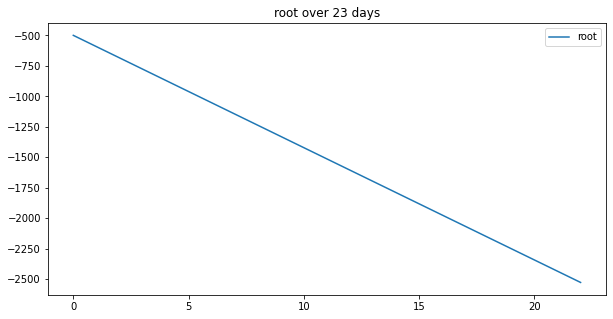

In [259]:
IT.visualize_range('root', '09092021', '10012021', 7)

In [260]:
IT.pretty_print_index()

Nodes per Month:
 root $-3263.43
    money $-2063.43
       tuition&fees $-1606.0
          rent $-1598.0
          sci_fees $-8.0
       shoes $-900.0
       debt $442.57
    food $-1200.0
